## Шаг 1. Загрузка и первичная обработка данных

In [17]:
from __future__ import division, print_function  # Используется для обеспечения совместимости с Python 2
%matplotlib inline
from matplotlib import pyplot as plt  # Построение графиков
import seaborn as sns  # Визуализация данных с улучшенным дизайном
from google.colab import files  # Загрузка файлов в Google Colab
import pickle  # Работа с бинарными файлами для сохранения/загрузки объектов Python
import numpy as np  # Работа с массивами и матрицами чисел
import pandas as pd  # Работа с табличными данными
from sklearn.preprocessing import StandardScaler  # Нормализация данных
from sklearn.metrics import roc_auc_score  # Вычисление метрики качества классификации (AUC-ROC)
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.model_selection import train_test_split  # Разделение данных на обучающую и тестовую выборки
from sklearn.model_selection import GridSearchCV  # Подбор гиперпараметров с кросс-валидацией
from sklearn.metrics import roc_curve, auc  # Построение ROC-кривой и вычисление площади под ней

data_path = 'diabetes.csv'

# Чтение файла CSV в DataFrame
df = pd.read_csv(data_path)

print(df.info())  # Информация о типах данных и количестве пропущенных значений
print(df.describe())  # Статистическое описание числовых данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

## Шаг 2. Создание признаков для обучения

In [18]:
y = df['Outcome']

# Создание новых синтезированных признаков
# Пример: связь между индексом массы тела (BMI) и возрастом пациента
df['BMI_Age'] = df['BMI'] * df['Age']
# Пример: соотношение уровня глюкозы к артериальному давлению
df['Glucose_BloodPressure'] = df['Glucose'] / (df['BloodPressure'] + 1)  # Избежим деления на 0

# Выбор признаков для обучения
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI_Age', 'Glucose_BloodPressure']]

# Вывод первых строк признаков для проверки
print("\nПризнаки для обучения:")
print(X.head())



Признаки для обучения:
   Pregnancies  Glucose  BloodPressure  BMI_Age  Glucose_BloodPressure
0            6      148             72   1680.0               2.027397
1            1       85             66    824.6               1.268657
2            8      183             64    745.6               2.815385
3            1       89             66    590.1               1.328358
4            0      137             40   1422.3               3.341463


## Шаг 3. Разделение данных

In [19]:
# Разделение данных на обучающую и тестовую выборки
# 80% для обучения, 20% для тестирования
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Замена пропущенных значений на медиану в обучающих и тестовых наборах
X_train = X_train.apply(lambda x: x.fillna(x.median()), axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.median()), axis=0)
y_train = y_train.fillna(y_train.median())
y_test = y_test.fillna(y_test.median())

# Проверка размеров обучающих и тестовых наборов
print("\nРазмеры наборов данных:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")


Размеры наборов данных:
X_train: (614, 5), X_test: (154, 5)
y_train: (614,), y_test: (154,)


## Шаг 4. Масштабирование признаков

In [20]:
# Преобразование признаков к единому масштабу (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Обучение и преобразование обучающего набора
X_test_scaled = scaler.transform(X_test)  # Преобразование тестового набора

# Проверка первых 5 строк после масштабирования
print("\nПервые 5 строк после масштабирования:")
print(X_train_scaled[:5])


Первые 5 строк после масштабирования:
[[-0.52639686 -1.15139792 -3.75268255 -2.43777966  3.43276966]
 [ 1.58804586 -0.27664283  0.68034485  0.82686039 -0.21178883]
 [-0.82846011  0.56687102 -1.2658623  -0.97586922 -0.14088034]
 [-1.13052335  1.2541786  -1.04961706  0.85811758 -0.1320869 ]
 [ 0.68185612  0.41066475  0.57222224  2.48279696 -0.19834293]]


## Шаг 5. Моделирование: логистическая регрессия

In [21]:
# Подбор гиперпараметра регуляризации C
params = {'C': np.logspace(-3, 3, 10)}  # Сетка значений гиперпараметра
lr = LogisticRegression(max_iter=1000, random_state=42)
grid = GridSearchCV(lr, params, scoring='roc_auc', cv=5)  # Кросс-валидация

# Обучение модели с подбором гиперпараметров
grid.fit(X_train_scaled, y_train)

# Оптимальный гиперпараметр
best_model = grid.best_estimator_  # Модель с лучшим результатом
best_C = grid.best_params_['C']  # Лучшее значение C
print(f"Лучшее значение C: {best_C}")

Лучшее значение C: 2.154434690031882


## Шаг 6. Оценка модели

In [22]:
# Вычисление вероятностей принадлежности к классу 1 (диабет)
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Расчет метрики AUC-ROC (качество классификации)
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {auc_score}")

AUC-ROC: 0.7829201101928375


## Шаг 7. Графический анализ зависимости AUC-ROC от C

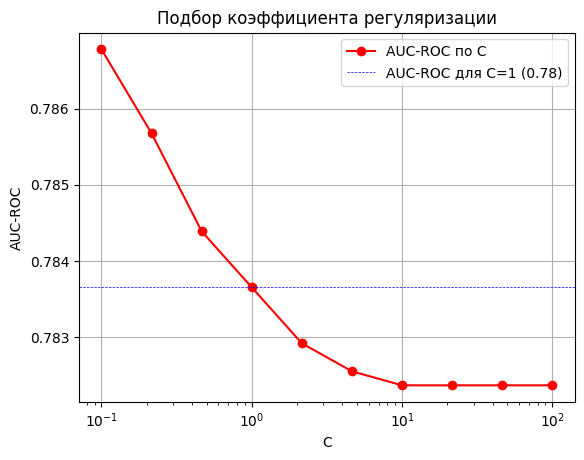

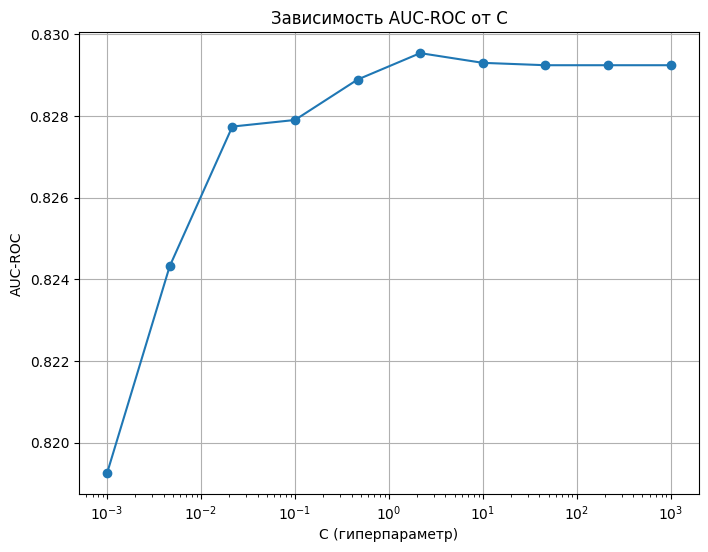

In [23]:
# Расчет AUC-ROC для различных значений C
Cs = np.logspace(-1, 2, 10)  # Значения C
scores = []

for C_val in Cs:
    lr = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train)
    y_pred_prob = lr.predict_proba(X_test_scaled)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_prob)
    scores.append(auc_score)

# AUC-ROC для значения C=1
lr_default = LogisticRegression(C=1, max_iter=1000, random_state=42)
lr_default.fit(X_train_scaled, y_train)
y_pred_prob_default = lr_default.predict_proba(X_test_scaled)[:, 1]
score_C_1 = roc_auc_score(y_test, y_pred_prob_default)

# Построение графика зависимости AUC-ROC от C
plt.plot(Cs, scores, 'ro-', label='AUC-ROC по C')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed', label=f'AUC-ROC для C=1 ({score_C_1:.2f})')
plt.legend()
plt.grid()
plt.show()

# Дополнительный график на основе кросс-валидации
results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8, 6))
plt.semilogx(results['param_C'], results['mean_test_score'], marker='o')
plt.xlabel('C (гиперпараметр)')
plt.ylabel('AUC-ROC')
plt.title('Зависимость AUC-ROC от C')
plt.grid()
plt.show()

## Шаг 8. Сохранение результатов

In [24]:
# Формирование DataFrame с результатами
baseline_metrics = []

for i in range(len(df)):
    row_metrics = {
        'Pregnancies': df['Pregnancies'].iloc[i],
        'Glucose': df['Glucose'].iloc[i],
        'Best_C': best_C,
        'AUC-ROC': auc_score
    }
    baseline_metrics.append(row_metrics)

baseline_df = pd.DataFrame(baseline_metrics)

# Сохранение результатов в CSV файл
baseline_path = 'baseline_metrics.csv'
baseline_df.to_csv(baseline_path, index=False)

# Вывод первых строк файла с метриками
print(baseline_df.head())

   Pregnancies  Glucose    Best_C   AUC-ROC
0            6      148  2.154435  0.782369
1            1       85  2.154435  0.782369
2            8      183  2.154435  0.782369
3            1       89  2.154435  0.782369
4            0      137  2.154435  0.782369


## Вывод

1. В ходе анализа данных, модель логистической регрессии была обучена для прогнозирования вероятности заболевания на основе ряда признаков, таких как количество беременностей, уровень глюкозы. 
2. Гиперпараметр регуляризации C, равный 2.154, показал оптимальный баланс между качеством классификации и предотвращением переобучения, что отражается в среднем значении метрики AUC-ROC 0.782. Это свидетельствует о том, что модель достаточно точно классифицирует пациентов на группы с диабетом и без него.
